# **Import Libraries and Framework**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
import keras
from tensorflow.keras.metrics import F1Score
import re, math
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import backend as K
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

2024-03-15 02:45:34.077428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 02:45:34.077525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 02:45:34.207715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.15.0


# **Distribution Strategy**

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(gpu)
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
REPLICAS:  1


# **Understanding TFRecord Data Structure**

In [3]:
# Understanding TFRecord files structure

raw_dataset = tf.data.TFRecordDataset("/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/val/05-192x192-232.tfrec")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)
    
# Each records contain several features like class, id, and image.

features {
  feature {
    key: "class"
    value {
      int64_list {
        value: 12
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "598ee68f2"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\000\300\000\300\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\001\004\003\001\001\001\000\000\000\000\000\000\000\000\000\007\004\005\006\010\002\003\t\001\000\n\377\304\000H\020\000\001\003\002\0

# **Loading the Comptetion Data**

In [4]:
# Get Google Clooud Storage path
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') # it's like /kaggle/input/tpu-getting-started
print(GCS_DS_PATH)

gs://kds-640d539e3f477f56e7d6179835af1e6036fd8d8c38004a998f411698


In [5]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-224x224'

# AUTOTUNE automatically chooses the optimal parallelism 
# for tf.data operations like map, batch, prefetch based on runtime hardware.
AUTO = tf.data.experimental.AUTOTUNE

# Dataset Path
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

# Flower Classes
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

In [6]:
# Data Preprocessing Function Definition

def decode_img(img_data):
    image = tf.image.decode_jpeg(img_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 # cast image to float32 in range [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # reshape image to size 512x512x3, explicit size needed for TPU
    return image
    
def parse_labeled_data(example_proto):
    feature_desc = {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example_proto, feature_desc)
    image = decode_img(example['image'])
    label = tf.cast(example['class'], tf.int32)
    label = tf.one_hot(label, 104)
    return image, label
    
def parse_unlabeled_data(example_proto):
    feature_desc = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example_proto, feature_desc)
    idnum = example['id']
    image = decode_img(example['image'])
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        # This will make the interleave order non-deterministic, increase speed
        ignore_order.deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # num_parallel_calls for parallelism
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_labeled_data if labeled else parse_unlabeled_data, num_parallel_calls=AUTO)
    # returns (image, class) pair if labeled=True or (image, id) pair if labeled=False
    return dataset

# **Create Data Pipeline**

In [7]:
# Data Augmentation Function
def data_augment(label, image):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_crop(image, size=[512, 512, 3])
    image = tf.image.random_contrast(image, lower=0.7, upper=1.4)
    return image, label 

# Training Dataset Loading Function
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# Validation Dataset Loading Function
def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Test Dataset Loading Function
def get_test_dataset():
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [8]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [9]:
with strategy.scope():
    train_ds = get_training_dataset()
    valid_ds = get_validation_dataset()
    test_ds = get_test_dataset()
    
print("Training:", train_ds)
print("Validation:", valid_ds)
print("Test:", test_ds)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 104), dtype=tf.float32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 104), dtype=tf.float32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


# **Explore Data**

## Checking the Distribution of Each Class

In [10]:
count_class = []
for i in range(104):
    count_class.append(0);

ds_train = get_training_dataset().unbatch()
train_label = iter(ds_train)

for i in range(NUM_TRAINING_IMAGES):
    image, label = next(train_label)
    count_class[np.argmax(label)] = count_class[np.argmax(label)]+1
    
print(count_class)

[269, 28, 17, 23, 688, 87, 18, 106, 87, 85, 143, 43, 95, 262, 222, 21, 55, 47, 88, 25, 19, 104, 50, 19, 86, 86, 26, 33, 110, 107, 108, 23, 23, 18, 18, 35, 58, 22, 18, 74, 61, 97, 65, 103, 21, 174, 133, 269, 434, 555, 196, 103, 121, 445, 36, 56, 88, 61, 37, 54, 28, 28, 98, 28, 58, 30, 20, 786, 260, 98, 110, 141, 172, 461, 121, 306, 119, 141, 89, 116, 150, 101, 128, 119, 31, 29, 123, 147, 95, 48, 108, 109, 23, 138, 127, 126, 98, 42, 37, 24, 33, 25, 385, 742]


In [11]:
print(sum(count_class) == NUM_TRAINING_IMAGES)

True


## Displaying Images 

In [12]:
# Convert TensorFlow batch to numpy arrays for labels and images
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # if it's a byte string (or id)
        numpy_labels = [None for _ in enumerate(numpy_labels)]
    return numpy_images, numpy_labels 

# Generates a title for display on an image based on the predicted label and the ground truth label
def title_from_label_and_target(label, correct_label):
    if correct_label == None:
        return CLASSES[label], True
    correct = (label == correct_label)
    title = "{} [{}{}{}]".format(CLASSES[label], 
                                 'OK' if correct else 'NO', 
                                 u"\u2192" if not correct else '',
                                 CLASSES[correct_label] if not correct else '')
    return title, correct

# Displays a single flower image along with its title on a subplot
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    # Set up the subplot
    plt.subplot(*subplot)
    plt.axis('off')
    
    # Display the flower image
    plt.imshow(image)
    
    # Customize and display the title
    if len(title) > 0:
         plt.title(title, 
              fontsize=int(titlesize) if not red else int(titlesize/1.2),
              color='red' if red else 'black',
              fontdict={'verticalalignment': 'center'},
              pad=int(titlesize/1.5))
    
    return (subplot[0], subplot[1], subplot[2]+1) # Move to next index
    
# Displays every images in databatch
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # Convert Data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    # Data Handling
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    
    # Size and Spacing Plot
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
        
    # Getting Titles
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])): # enumerate() returns index and value each element,
                                                                                     # zip() merge elements of 2 iterable.
        title = '' if label is None else CLASSES[np.argmax(label)]
        correct = True
        if predictions is not None:
            # Getting title from predicted label and true label
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize) # display image and move to next index
    
    # Layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [13]:
# Change the batch size for displaying images
ds_iter = iter(train_ds.unbatch().batch(20))

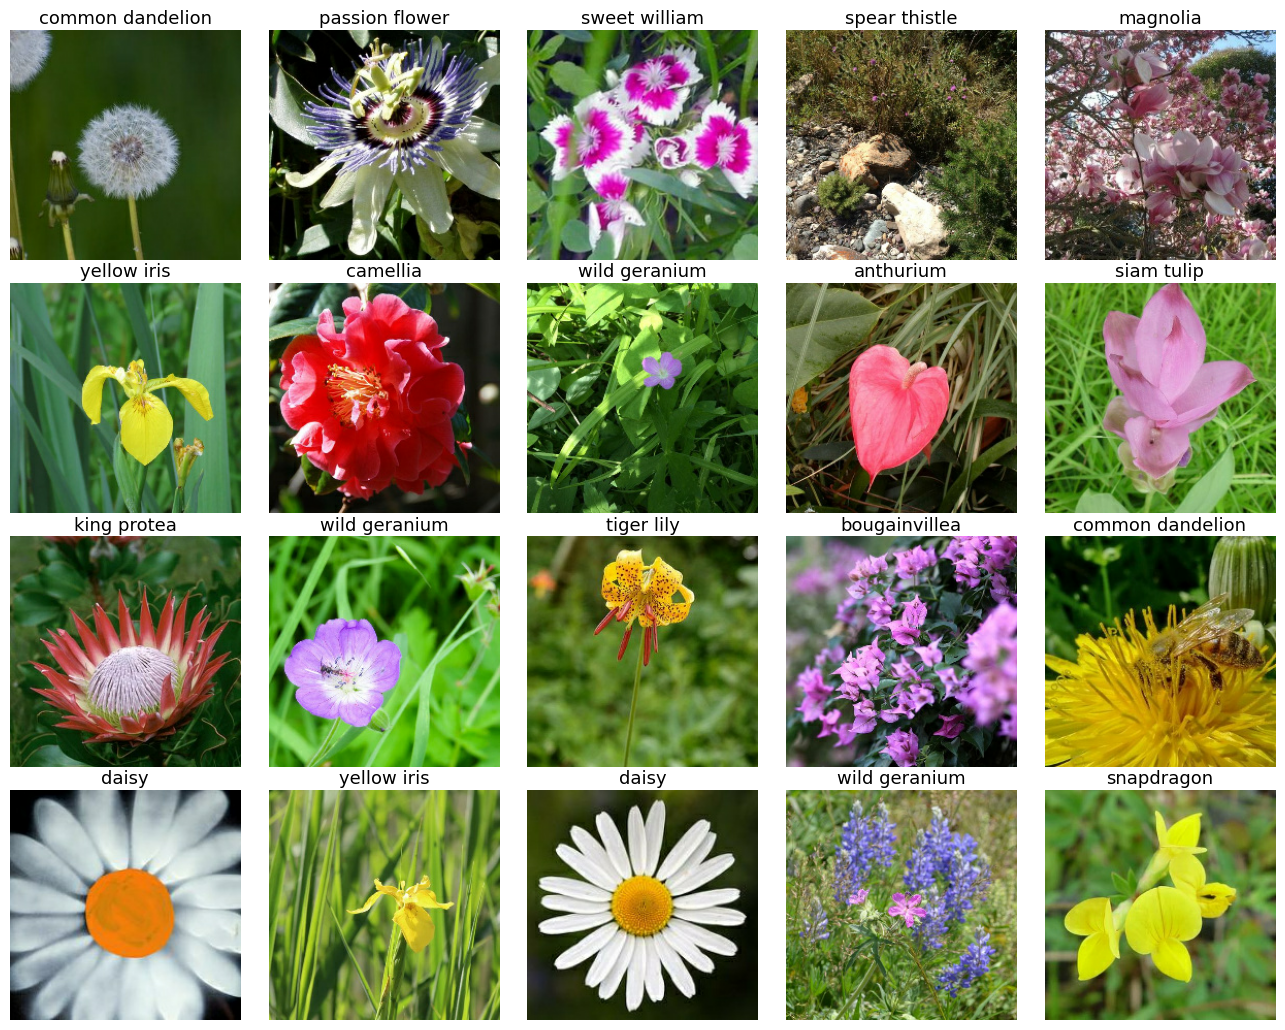

In [14]:
# Iterating each batch to display every images
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

## Displaying Metrics

In [15]:
# Displaying accuracy and loss of trained model
def display_training_curves(training, validation, title, subplot):
    # If this is the first call to the function, create a new subplot
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    
    # Create a subplot with the corresponding number
    ax = plt.subplot(subplot)
    
    # Set the background color of the subplot
    ax.set_facecolor('#F8F8F8')
    
    # Display training and validation curves on the subplot
    ax.plot(training)
    ax.plot(validation)
    
    # Add information to the subplot
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    
    # Add a legend for the training and validation curves
    ax.legend(['train', 'valid'])

# Defining, Compiling, and Training Model

## Setting the Class Weight

In [16]:
train_label = []

unbatched_data = train_ds.unbatch()
train_iter = iter(unbatched_data)

for i in range(NUM_TRAINING_IMAGES):
    image, label = next(train_iter)
    train_label.append(np.argmax(label))

In [17]:
np.unique(train_label)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103])

In [18]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_label), y=train_label)

## Dictionary of Pre-Trained Model

In [19]:
# List of Pre-Trained Model
with strategy.scope():
    # Listing pretrained model will be used
    pretrained = {
        'DenseNet201': DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3]),           # 1
        'EfficientNetB7': EfficientNetB7(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3]),     # 2
        'EfficientNetV2L': EfficientNetV2L(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3]),   # 3
        'EfficientNetV2B3': EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3]), # 4
        'Xception': Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])                  # 5
    }
    
    # Setting pre-trained model to un-trainable
    for pre_model in pretrained:
        pretrained[pre_model].trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [20]:
for i in pretrained:
    print(i)

DenseNet201
EfficientNetB7
EfficientNetV2L
EfficientNetV2B3
Xception


## Learning Rate Scheduler

Learning rate schedule: 1e-05 to 5e-05 to 1.22e-05


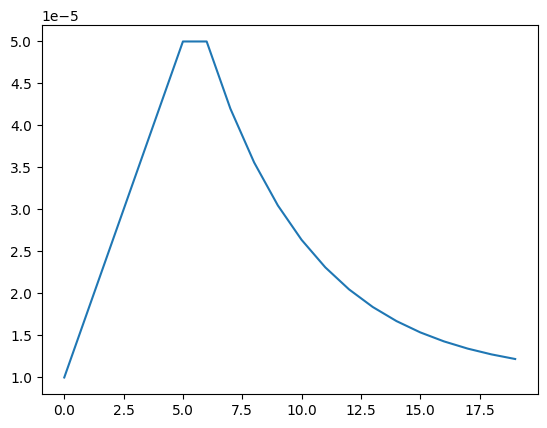

In [21]:
# Learning Rate Schedule for Fine Tuning #

# Function to calculate learning rate based on an exponential schedule
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync,
                   rampup_epochs = 5, sustain_epochs = 1,
                   exp_decay = 0.8):

    # Internal function to compute learning rate at each epoch
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # Linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # Constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # Exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr

    # Call the internal function with specified parameters for the current epoch
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

# Define callback for model training
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=1)

EPOCHS = 20
rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3} to {:.3} to {:.3}".format(y[0], max(y), y[-1]))

In [22]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint-{epoch:02d}-{val_loss:.2f}.weights.h5',
                                                 save_weights_only=True,
                                                 monitor='val_f1_score',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

## Training Model

In [23]:
# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [24]:
train_history = []
# Fit Model with Training Data and Validation Data
with strategy.scope():
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained['DenseNet201'],
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
        optimizer = Nadam(),
        loss = 'categorical_crossentropy', 
        metrics = ['categorical_accuracy', F1Score(average='macro')]
    )

    model.summary()

    history = model.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        callbacks = [lr_callback, cp_callback],
        class_weight=dict(enumerate(class_weights))
    )

    train_history.append(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               199784    
                                                                 
Total params: 18521768 (70.65 MB)
Trainable params: 199784 (780.41 KB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/12
  1/797 [..............................] - ETA: 5:00:27 - loss: 2.9631 - categorical_accuracy: 0.0000e+00 - f1_score

I0000 00:00:1710470928.968433      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


797/797 [==============================] - ETA: 0s - loss: 2.0052 - categorical_accuracy: 0.5843 - f1_score: 0.5103
Epoch 1: val_f1_score improved from -inf to 0.72274, saving model to model_checkpoint-01-1.12.weights.h5
797/797 [==============================] - 95s 91ms/step - loss: 2.0052 - categorical_accuracy: 0.5843 - f1_score: 0.5103 - val_loss: 1.1196 - val_categorical_accuracy: 0.7368 - val_f1_score: 0.7227 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/12
797/797 [==============================] - ETA: 0s - loss: 0.6536 - categorical_accuracy: 0.8136 - f1_score: 0.8061
Epoch 2: val_f1_score improved from 0.72274 to 0.78971, saving model to model_checkpoint-02-0.84.weights.h5
797/797 [==============================] - 64s 80ms/step - loss: 0.6536 - categorical_accuracy: 0.8136 - f1_score: 0.8061 - val_loss: 0.8363 - val_categorical_accuracy: 0.8023 - val_f1_score: 0.7897 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler sett

# Evaluate Model Predictions

## Displaying Confusion Matrix

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [26]:
cmdataset = get_validation_dataset()
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_iter = iter(cmdataset.unbatch().batch(1))
cm_iter = iter(cmdataset.unbatch().batch(NUM_VALIDATION_IMAGES))
cm_data = next(cm_iter)

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_target = np.argmax(cm_correct_labels, axis=-1)
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_target,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

232/232 [==============================] - 15s 49ms/step


In [27]:
cm_predictions

array([50, 82, 99, ...,  8, 12, 67])

In [28]:
cm_target

array([50, 82, 99, ...,  8, 12, 67])

0.8375171455218395
0.8292769750602941
0.8566506874277697


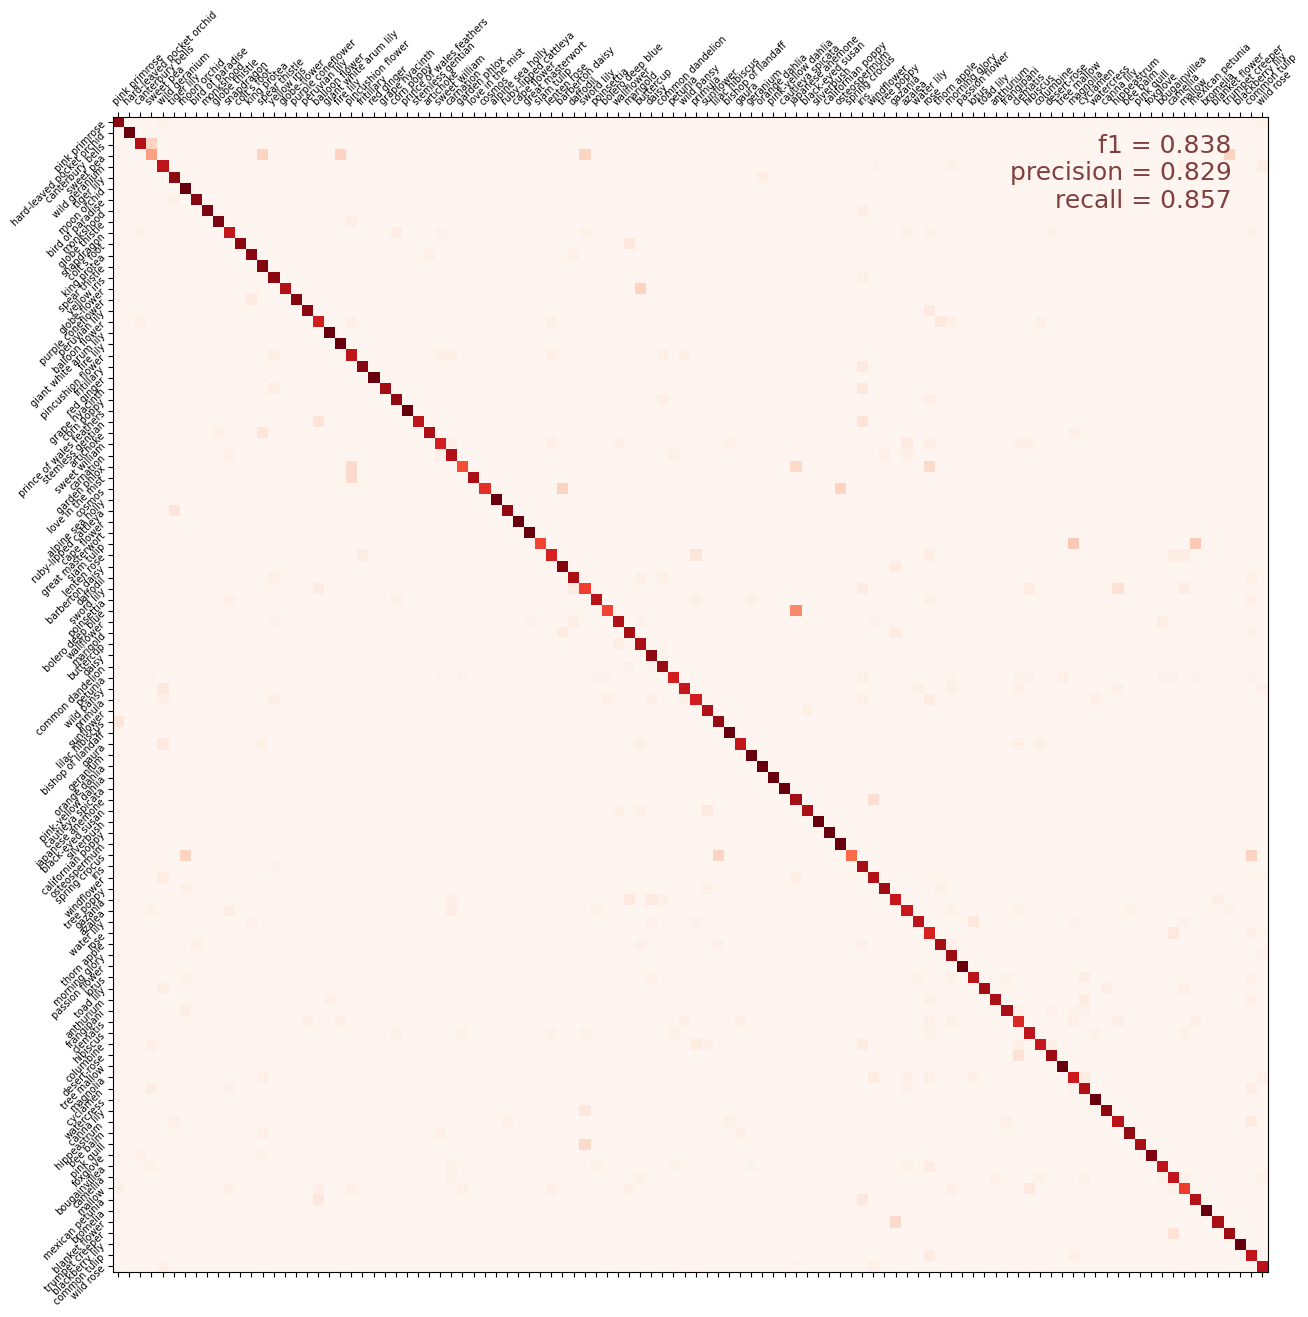

In [29]:
score = f1_score(
    cm_target,
    cm_predictions,
    labels=labels,
    average='macro',
)
print(score)

precision = precision_score(
    cm_target,
    cm_predictions,
    labels=labels,
    average='macro',
)
print(precision)

recall = recall_score(
    cm_target,
    cm_predictions,
    labels=labels,
    average='macro',
)
print(recall)

display_confusion_matrix(cmat, score, precision, recall)

In [30]:
model.evaluate(valid_ds)

232/232 [==============================] - 13s 55ms/step - loss: 0.6585 - categorical_accuracy: 0.8443 - f1_score: 0.8375


[0.6585032343864441, 0.8442887663841248, 0.8375171422958374]

## Second Pre-Trained Model: Xception

In [31]:
with strategy.scope():
    model2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained['Xception'],
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model2.compile(
        optimizer = Nadam(),
        loss = 'categorical_crossentropy', 
        metrics = ['categorical_accuracy', F1Score(average='macro')]
    )

    model2.summary()

    history = model2.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        callbacks = [lr_callback, cp_callback],
        class_weight=dict(enumerate(class_weights))
    )

    train_history.append(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 104)               213096    
                                                                 
Total params: 21074576 (80.39 MB)
Trainable params: 213096 (832.41 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/12
796/797 [============================>.] - ETA: 0s - loss: 2.0990 - categorical_accuracy: 0.5160 - f1_score: 0.449

In [32]:
model2.evaluate(valid_ds)

232/232 [==============================] - 10s 41ms/step - loss: 1.0077 - categorical_accuracy: 0.7478 - f1_score: 0.7392


[1.007698893547058, 0.7478448152542114, 0.7392455339431763]

## Ensemble Model: DenseNet201 + Xception

In [33]:
probabilities_ens = (model.predict(images_ds) + model2.predict(images_ds)) / 2
predictions_ens = np.argmax(probabilities_ens, axis=-1)

232/232 [==============================] - 10s 37ms/step


In [34]:
score = f1_score(
    cm_target,
    predictions_ens,
    labels=labels,
    average='macro',
)
print(score)

0.8462697402836242


## Displaying How Loss and Metrics Progressed During Training

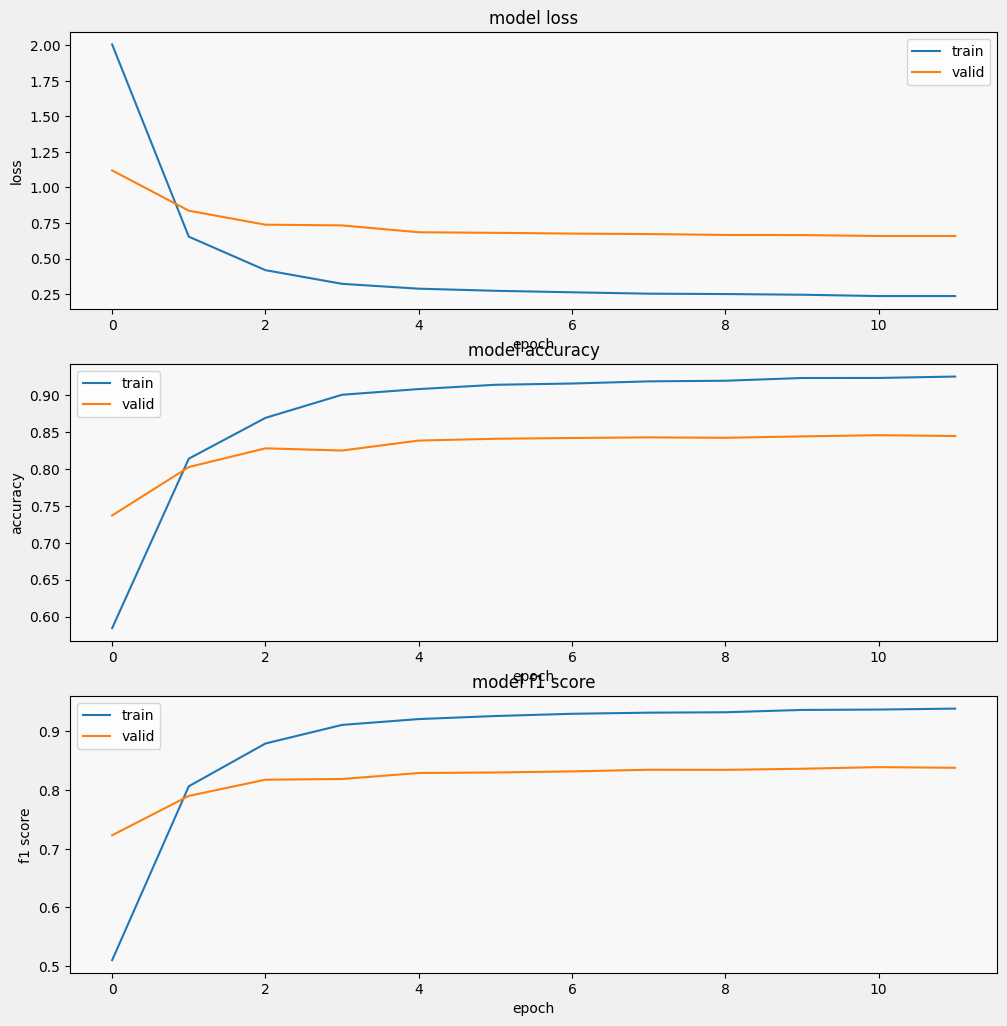

In [35]:
for i in range(1):
    # Displaying model loss
    display_training_curves(
        train_history[i].history['loss'],
        train_history[i].history['val_loss'],
        'loss',
        311,
    )

    # Displaying model accuracy
    display_training_curves(
        train_history[i].history['categorical_accuracy'],
        train_history[i].history['val_categorical_accuracy'],
        'accuracy',
        312,
    )
    
    display_training_curves(
        train_history[i].history['f1_score'],
        train_history[i].history['val_f1_score'],
        'f1 score',
        313,
    )

# Make Test Prediction

In [36]:
"""test_ds = get_test_dataset()

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)"""

"test_ds = get_test_dataset()\n\nprint('Computing predictions...')\ntest_images_ds = test_ds.map(lambda image, idnum: image)\nprobabilities = model.predict(test_images_ds)\npredictions = np.argmax(probabilities, axis=-1)\nprint(predictions)"

In [37]:
test_ds = get_test_dataset()

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = (model.predict(test_images_ds) + model2.predict(test_images_ds)) / 2
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
462/462 [==============================] - 22s 39ms/step
[67 28 88 ... 18 94 62]


In [38]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
dfd946ac8,88
6e644aad3,49
0c3ae4377,81
98f62f563,69
a31f90373,67
855229539,77
0bf251179,95
